# load float log

In [1]:
import os
from glob import glob
import yaml

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import cognac.float as fl
import cognac.float.seabot as sb

---
## load data

In [3]:
root_dir = '/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin0_bags/'
bag = 'pd_2020-06-10-15-55-17_0'
bdata = sb.load_bag(root_dir+bag)

#for b, d in bdata.items():
#    print(b, list(d))

# load config file
#file = root_dir+'config_ifremer1.yaml'
#cfg = load_config(file)
#
log_file = root_dir+'20200610_m10bis.log'
cfg = sb.load_config_from_log(log_file)
#cfg

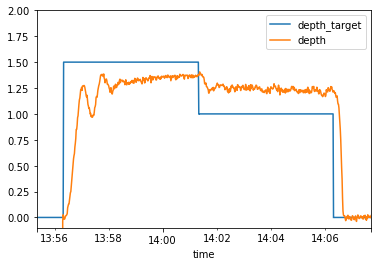

In [5]:
df_gen = sb.resample_join('1s',
                       bdata['mission']['depth'].rename('depth_target'),
                       bdata['depthFusion']['depth']
                      )
_ = df_gen.plot(ylim=(-.1, 2.))

In [7]:
### prepare data for kalman filter
ph = cfg['physics']
pressure2depth = 1e5/(ph['rho']*ph['g'])
Cf = np.pi*(ph['diam_collerette']/2.)**2
B = 0.5*ph['rho']*Cf/ph['m']
A = ph['g']*ph['rho']/ph['m']

f = fl.autonomous_float(model='Ifremer', m=ph['m'])
f.init_piston()

tick_to_volume = f.piston.vol_increment
print('tick_to_volume = {:.2e}'.format(tick_to_volume))

gamma_alpha, gamma_init, gamma_beta = sb.get_kf_parameters(cfg, tick_to_volume)

Piston max volume set from max displacement
tick_to_volume = 2.56e-08


In [8]:
# seabot kalman state
kalman_state = (bdata['kalman'][[c for c in bdata['kalman'].columns if 'cov' not in c]]
                .drop(columns='seconds')
               )
kalman_cov = bdata['kalman'][[c for c in bdata['kalman'].columns if 'cov' in c]]

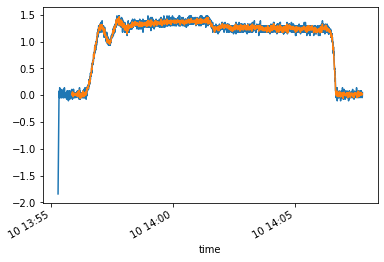

In [9]:
# observations timeseries
depth = bdata['sensorExt']['pressure'].rename('depth')*pressure2depth
dt = bdata['sensorExt']['seconds'].diff().median()
offset = depth.resample('5s').mean()[2:].min()
depth = depth - offset
depth.plot()

df = sb.resample_join('500ms', 
                   depth,
                   bdata['pistonState']['position'].rename('v')*tick_to_volume,
                  )

enable_depth = cfg['kalman']['enable_depth']
# !!! enable depth is not correct here, should increase value to 0.2m in config file !!!
#df = df[df['depth']>enable_depth*2]
df.depth.plot()

In [11]:
# not working
#velocity = depth.diff()/(depth.index-depth.index[0]).total_seconds().to_series().diff()
#velocity.plot()

In [10]:
# from seabot library
#xhat(0) = velocity_fusion;
#xhat(1) = depth;
#xhat(2) = piston_volume_eq; // Vp
#xhat(3) = -1.0*tick_to_volume; // chi
#xhat(4) = 0.*tick_to_volume; // chi2
#xhat(5) = 1.0; // Cz   

x_init = [0., 
          depth[0], 
          ph['piston_ref_eq']*tick_to_volume, 
          -1.0*tick_to_volume, 
          0.*tick_to_volume,
          1.]

dt = (depth.index-depth.index[0]).total_seconds().to_series().diff().median()

In [11]:
kf = sb.kalman(x_init,
               gamma_init,
               gamma_alpha,
               gamma_beta,
               dt,
               A,
               B,
              )
out = kf.simulate(df)

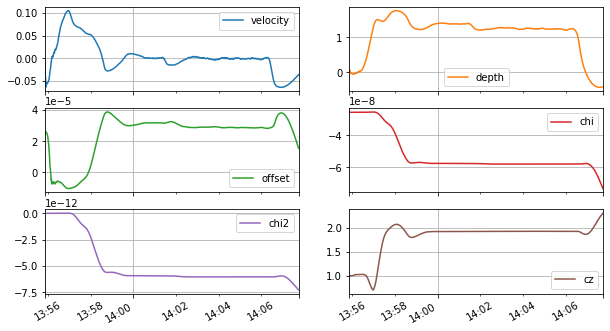

In [12]:
_ = out.plot(subplots=True, grid=True, layout=(5,2), figsize=(10,10))

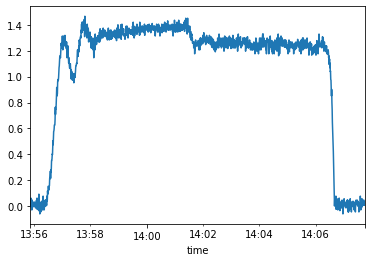

In [13]:
df['depth'].plot()

In [14]:
syn = sb.resample_join('500ms', 
              df['depth'].rename('depth_raw'),
              out.rename(columns={c: c+'_sim' for c in out.columns}),
              kalman_state.rename(columns={c: c+'_seabot' for c in kalman_state.columns}),
             )

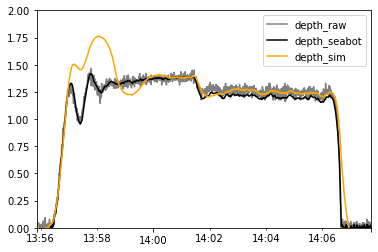

In [15]:
fig, ax = plt.subplots(1,1)
syn['depth_raw'].plot(color='0.5', ax=ax)
syn['depth_seabot'].plot(color='k', ax=ax)
syn['depth_sim'].plot(color='orange', ax=ax)
ax.set_ylim((0,2))
ax.legend()

In [ ]:
# not working !?
#fig, ax = plt.subplots(1,1)
#df['depth'].plot(color='0.5', ax=ax)
#kalman_state['depth'].plot(color='k', ax=ax)
#out['depth'].plot(color='orange', ax=ax)
#ax.set_ylim((0,2))

---
## kalman filter

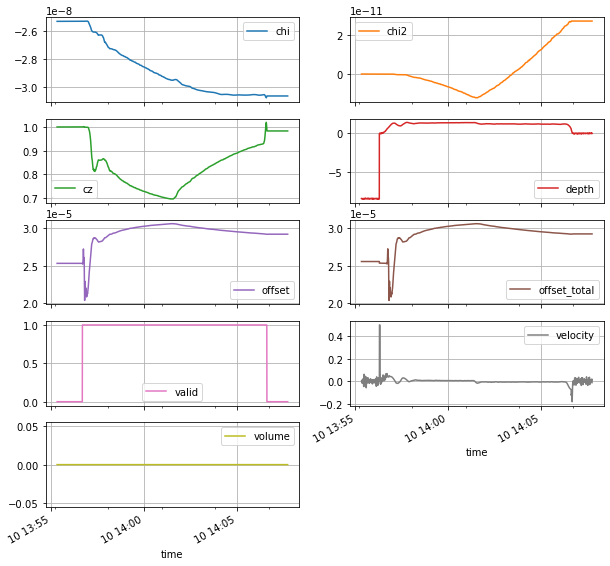

In [7]:
_ = kalman_state.plot(subplots=True, grid=True, layout=(5,2), figsize=(10,10))

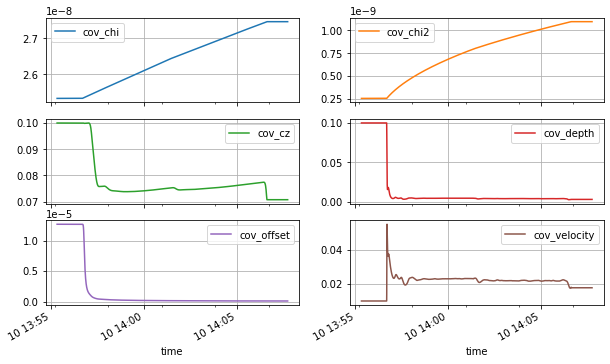

In [55]:
_ = np.sqrt(kalman_cov).plot(subplots=True, grid=True, layout=(5,2), figsize=(10,10))

In [51]:
pd.options.display.float_format = '{:,.2e}'.format
kalman_state[kalman_state['valid']==1].iloc[:2]

,chi,chi2,cz,depth,offset,offset_total,valid,velocity,volume
time,,,,,,,,,
2020-06-10 13:56:41.772318827,-2.53e-08,0.00e+00,1.00e+00,5.03e-01,2.53e-05,2.53e-05,1,5.63e-02,2.67e-316
2020-06-10 13:56:41.973168439,-2.53e-08,2.13e-19,1.00e+00,5.15e-01,2.53e-05,2.53e-05,1,5.77e-02,3.00e-316


In [54]:
np.sqrt(kalman_cov[kalman_state['valid']==1].iloc[:2])

,cov_chi,cov_chi2,cov_cz,cov_depth,cov_offset,cov_velocity
time,,,,,,
2020-06-10 13:56:41.772318827,2.53e-08,2.54e-10,1.00e-01,9.60e-02,1.27e-05,1.39e-02
2020-06-10 13:56:41.973168439,2.53e-08,2.54e-10,1.00e-01,8.65e-02,1.27e-05,2.95e-02
